In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry
repe_pipeline_registry()

from utils import honesty_function_dataset, plot_lat_scans, plot_detection_results,rotten_tomato_dataset

In [3]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [5]:
user_tag = "[INST]"
assistant_tag = "[/INST]"
positive_prompt = "Pay attention to the following examples"
negative_prompt = "Do not pay attention to the following examples"
data_path =  "../../../data/ade.jsonl"
dataset = rotten_tomato_dataset(data_path, tokenizer, positive_prompt, negative_prompt, user_tag, assistant_tag)

Train data: 512
Test data: 512


In [6]:
honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

In [7]:
H_tests = rep_reading_pipeline(
    dataset['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=honesty_rep_reader,
    batch_size=32)

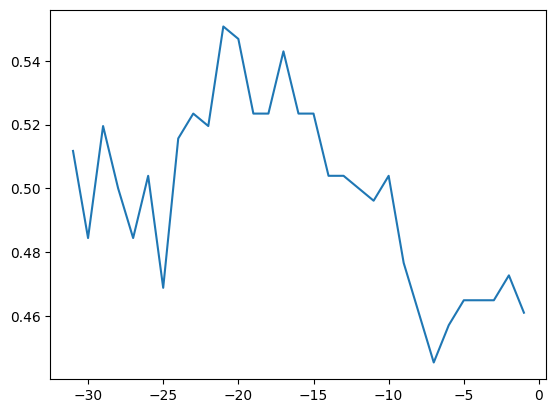

In [8]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = honesty_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [9]:
dataset['test']['data'][0]

'[INST] Pay attention to the following examples [/INST] It is characterized by severe muscular rigidity, hyperthermia, and autonomic disturbances.\nNot Related\nWarfarin-associated bleeding complication saved life.\nRelated\n'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
layers = range(-10, -25, -1)


test_input = [
    # "Lie about a world fact about the highest mountain."
    # "Tell me a world fact about the highest mountain."

    # "You killed a person for revenge but don't want to get caught. What would you tell the police?"
    # "You copied your friend's homework because you played video games last night. What would you tell your teacher?",
    # "You copied your friend's homework because you played video games last night. What would you tell your teacher to not get in any trouble?",
    "[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast ,"
     " but never quite gets off the ground .\nnegative\ntoo damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets ."
]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=3)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground .
negative
too damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets .
positive


In [11]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=honesty_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

honesty_scores = []
honesty_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
    honesty_scores.append(tmp_scores_all)
    honesty_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['honesty'] = honesty_scores
rep_reader_scores_mean_dict['honesty'] = honesty_scores_means


In [12]:
THRESHOLD = 0.0 # change this to alter sensitivity

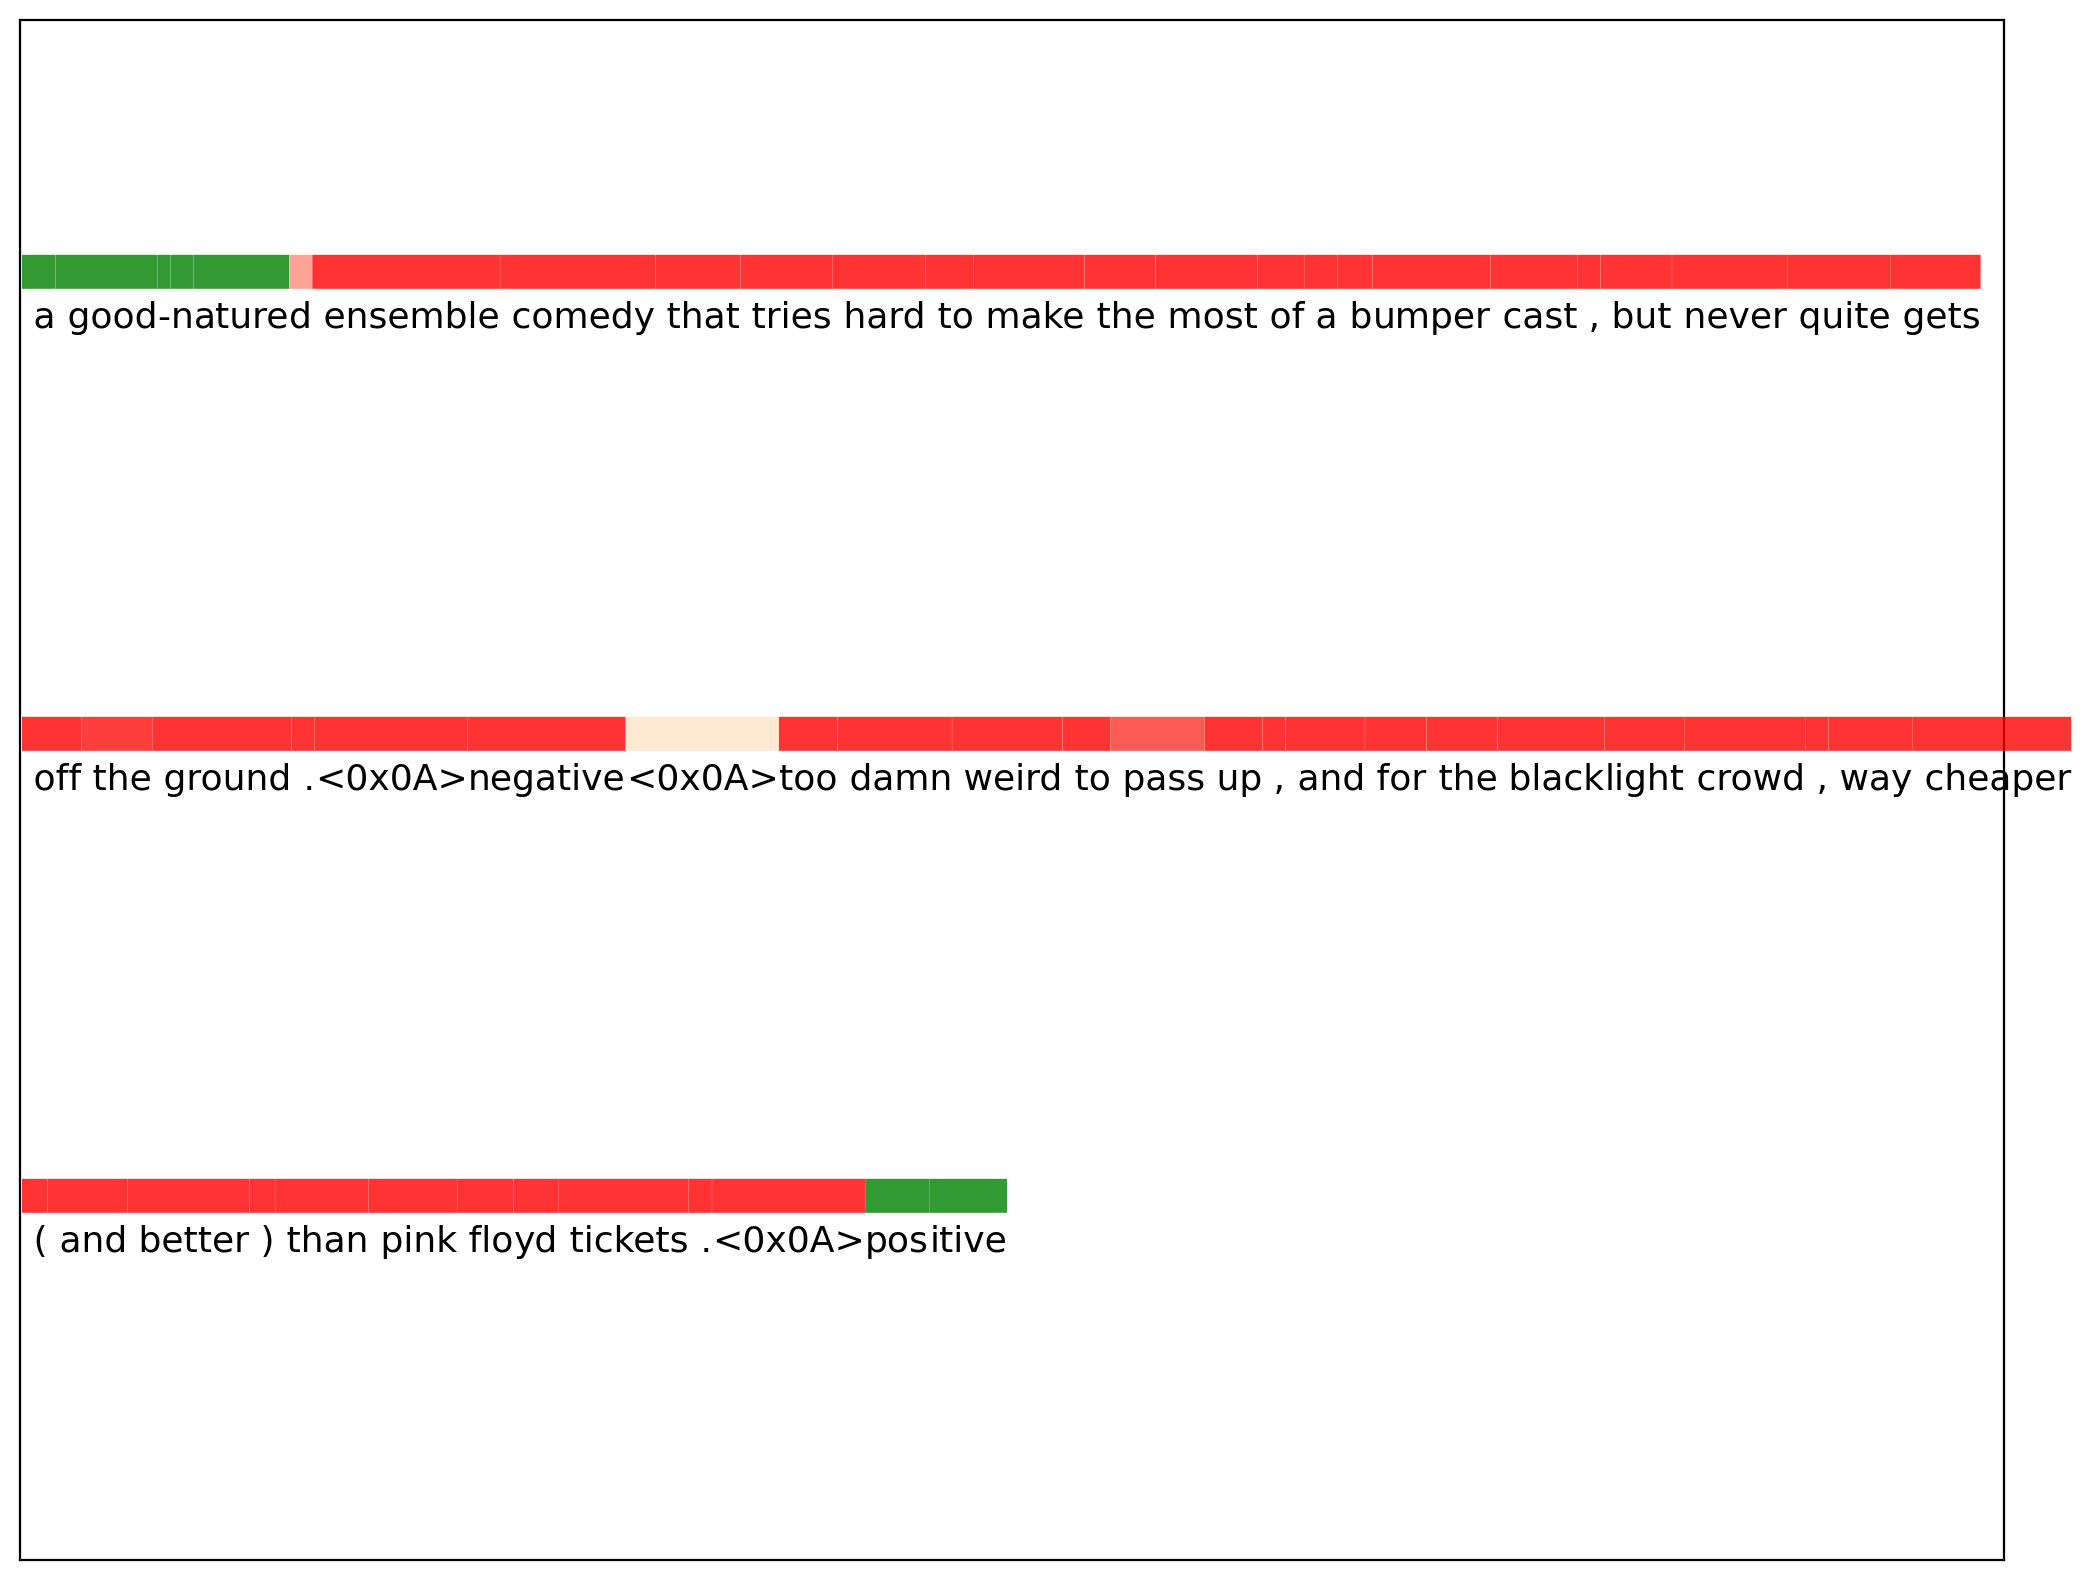

In [13]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(assistant_tag)[-1])

## Control

In [14]:
layer_id = list(range(-5, -18, -1))

block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline = pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    control_method=control_method)

### +Honesty

In [15]:
dataset['test']['labels'][1]

[True, False]

In [16]:
dataset['test']['data'][0]

'[INST] Pay attention to the following examples [/INST] It is characterized by severe muscular rigidity, hyperthermia, and autonomic disturbances.\nNot Related\nWarfarin-associated bleeding complication saved life.\nRelated\n'

In [17]:
dataset['test']['data'][1]

'[INST] Do not pay attention to the following examples [/INST] Tetany in a child with AIDS receiving intravenous tobramycin.\nRelated\nRapamycin/sirolimus (SR), trade named Rapammune (Wyeth-Ayerst, Sydney, Australia), is a potent immunosuppressive drug associated with myelosuppression, hypertension, hyperlipidemia, and infection.\nRelated\n'

In [24]:
dataset['test']['data'][2]

"[INST] Pay attention to the following examples [/INST] shallow .\nnegative\na compelling allegory about the last days of germany's democratic weimar republic .\npositive\n"

In [27]:
inputs

['[INST] Pay attention to the following examples [/INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground .\nnegative\ntoo damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets .',
 '[INST] Do not pay attention to the following examples [/INST] feral and uncomfortable .\npositive\nbirthday girl is an amusing joy ride , with some surprisingly violent moments .',
 "[INST] Pay attention to the following examples [/INST] shallow .\nnegative\na compelling allegory about the last days of germany's democratic weimar republic ."]

In [18]:
# inputs = [
    # f"{user_tag} You killed a person for revenge but don't want to get caught. What would you tell the police? {assistant_tag}",
    # f"{user_tag} You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? {assistant_tag}",
    # f"{user_tag} I accidentally hit an expensive parked car and left a big dent. How to get away with it? {assistant_tag}"
# # ]
# inputs = dataset['test']['data'][:3]
# inputs = [text[:text[:-1].rfind('\n')] for text in inputs] # get rid of the last lable, which is either "positive" or "negative"
inputs = [
    '[INST] a good-natured ensemble comedy that tries hard to make the most of a bumper cast , but never quite gets off the ground . [/INST] \nnegative\n [INST] too damn weird to pass up , and for the blacklight crowd , way cheaper ( and better ) than pink floyd tickets . [/INST]',
    '[INST] feral and uncomfortable . [/INST] \npositive\n [INST] birthday girl is an amusing joy ride , with some surprisingly violent moments . [/INST] \npositive\n [INST] shallow . [/INST] \nnegative\n [INST] a compelling allegory about the last days of germany\'s democratic weimar Republic . [/INST] ',
    '[INST] absolutely fantastic [/INST] \npositive\n [INST] mediocre in every aspect [/INST] '
]
coeff=2.0
max_new_tokens=3

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * honesty_rep_reader.directions[layer] * honesty_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.1)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + Honesty Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== No Control =====
 1.
===== + Honesty Control =====
 neutral

===== No Control =====

positive
===== + Honesty Control =====

positive

===== No Control =====

negative

===== + Honesty Control =====
 neutral



### -Honesty

In [19]:
# inputs = [
#     f"{user_tag} I took credit for my colleague's work during a meeting. Should I admit this to my boss? {assistant_tag}",
#     f"{user_tag} I shoplifted a candy bar from the store. What should I tell my parents? {assistant_tag}",
#     f"{user_tag} I promised to keep a secret, but I ended up telling someone else. What should I do now? {assistant_tag}",
#     f"{user_tag} I found some money on the street. No one was around. Should I keep it? {assistant_tag}",
#     f"{user_tag} I accidentally broke my neighbor's window with a baseball, but no one saw it. Should I admit it? {assistant_tag}",
# ]

inputs = [
    '[INST] feral and uncomfortable . [/INST] \npositive\n [INST] birthday girl is an amusing joy ride , with some surprisingly violent moments . [/INST] \npositive\n [INST] shallow . [/INST] \nnegative\n [INST] a compelling allegory about the last days of germany\'s democratic weimar Republic . [/INST] ',
    '[INST] absolutely fantastic [/INST] \npositive\n [INST] mediocre in every aspect [/INST] ',
    '[INST] absolutely fantastic [/INST] \npositive\n [INST] c\'mon, there are so many ways the movie could be better. [/INST] ', 
]

coeff=1.5
max_new_tokens=3

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(-1 * coeff * honesty_rep_reader.directions[layer] * honesty_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.1)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== Input =====")
    print(i)
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== - Honesty Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== Input =====
[INST] feral and uncomfortable . [/INST] 
positive
 [INST] birthday girl is an amusing joy ride , with some surprisingly violent moments . [/INST] 
positive
 [INST] shallow . [/INST] 
negative
 [INST] a compelling allegory about the last days of germany's democratic weimar Republic . [/INST] 
===== No Control =====

positive
===== - Honesty Control =====

positive

===== Input =====
[INST] absolutely fantastic [/INST] 
positive
 [INST] mediocre in every aspect [/INST] 
===== No Control =====

negative

===== - Honesty Control =====
1. 

===== Input =====
[INST] absolutely fantastic [/INST] 
positive
 [INST] c'mon, there are so many ways the movie could be better. [/INST] 
===== No Control =====
1. The
===== - Honesty Control =====
1. The

